In [1]:
import numpy as np
import pandas as pd
from prophet import Prophet
from prophet.plot import plot_plotly

d:\FutureVolt\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
# Load data with correct date format
df = pd.read_csv(
    "D:\FutureVolt\data\Quarter_Real_Estate.csv",
    parse_dates=['Date'],
    dayfirst=True  # Fix date format
)

In [3]:
# Prepare data frames
low_df = df[['Date', 'low_price']].rename(columns={'Date': 'ds', 'low_price': 'y'})
high_df = df[['Date', 'high_price']].rename(columns={'Date': 'ds', 'high_price': 'y'})

In [4]:
# Configure models with constraints
def create_model():
    return Prophet(
        seasonality_mode='additive',
        yearly_seasonality=True,
        daily_seasonality=False,
        changepoint_prior_scale=0.05,
        growth='linear'
    ).add_seasonality(name='quarterly', period=91.25, fourier_order=5)

In [5]:
# Set price floors
low_df['floor'] = 2000  # Minimum reasonable low price
high_df['floor'] = 10000  # Minimum reasonable high price

low_model = create_model()
high_model = create_model()

low_model.fit(low_df)
high_model.fit(high_df)

16:17:29 - cmdstanpy - INFO - Chain [1] start processing
16:17:30 - cmdstanpy - INFO - Chain [1] done processing
16:17:30 - cmdstanpy - INFO - Chain [1] start processing
16:17:30 - cmdstanpy - INFO - Chain [1] done processing


In [6]:
# Generate future dates
future = low_model.make_future_dataframe(
    periods=24,  # 6 years (4 quarters/year × 6)
    freq='QS-OCT'  # Quarter start with October year-end
)

In [7]:
# Make predictions
low_forecast = low_model.predict(future)
high_forecast = high_model.predict(future)

In [8]:
# Combine results
forecast = pd.merge(
    low_forecast[['ds', 'yhat']],
    high_forecast[['ds', 'yhat']],
    on='ds',
    suffixes=('_low', '_high')
)

In [9]:
# Filter only future predictions and format dates
final_forecast = forecast[forecast['ds'] > df['Date'].max()]
final_forecast['date'] = final_forecast['ds'].dt.strftime('%d-%m-%Y')  # Format change

# Display
print(final_forecast.round(1).to_string(index=False))

C:\Users\Admin\AppData\Local\Temp\ipykernel_8812\3305561138.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_forecast['date'] = final_forecast['ds'].dt.strftime('%d-%m-%Y')  # Format change


        ds  yhat_low  yhat_high       date
2025-01-01    3016.2   581283.2 01-01-2025
2025-04-01    2935.7   600423.9 01-04-2025
2025-07-01    2964.5   595705.9 01-07-2025
2025-10-01    2978.1   622707.6 01-10-2025
2026-01-01    2850.5   651903.0 01-01-2026
2026-04-01    2917.5   626748.9 01-04-2026
2026-07-01    2974.2   624228.8 01-07-2026
2026-10-01    2950.8   680880.0 01-10-2026
2027-01-01    2697.6   724276.0 01-01-2027
2027-04-01    2908.7   654001.4 01-04-2027
2027-07-01    3000.8   650693.4 01-07-2027
2027-10-01    2909.9   742784.2 01-10-2027
2028-01-01    2557.6   798376.4 01-01-2028
2028-04-01    2935.8   762139.5 01-04-2028
2028-07-01    2975.8   741602.2 01-07-2028
2028-10-01    2880.4   778103.7 01-10-2028
2029-01-01    2729.0   825748.7 01-01-2029
2029-04-01    2907.9   787572.2 01-04-2029
2029-07-01    2968.6   772167.9 01-07-2029
2029-10-01    2866.6   832503.7 01-10-2029
2030-01-01    2563.3   896368.4 01-01-2030
2030-04-01    2889.6   813897.3 01-04-2030
2030-07-01 

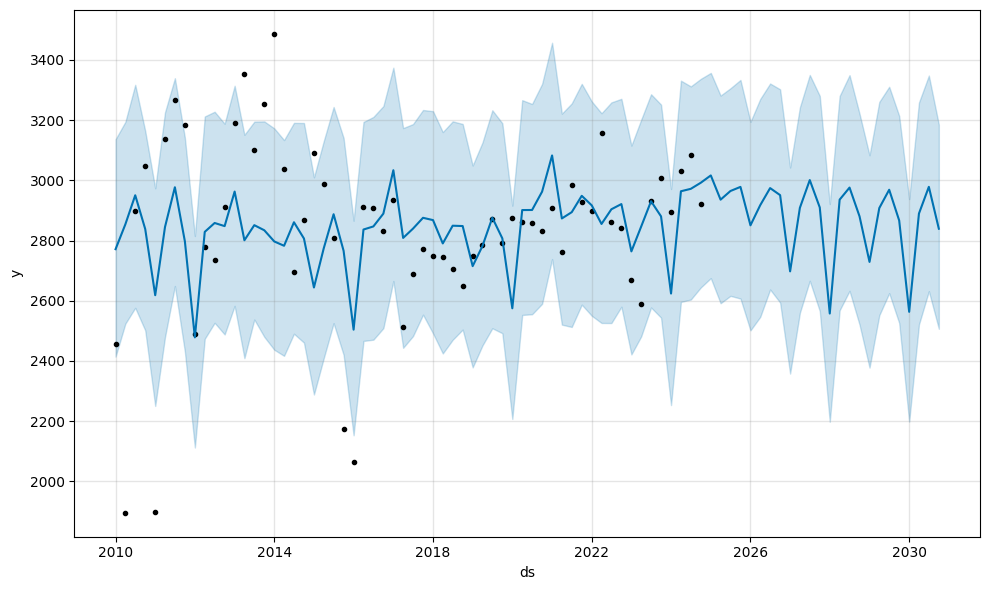

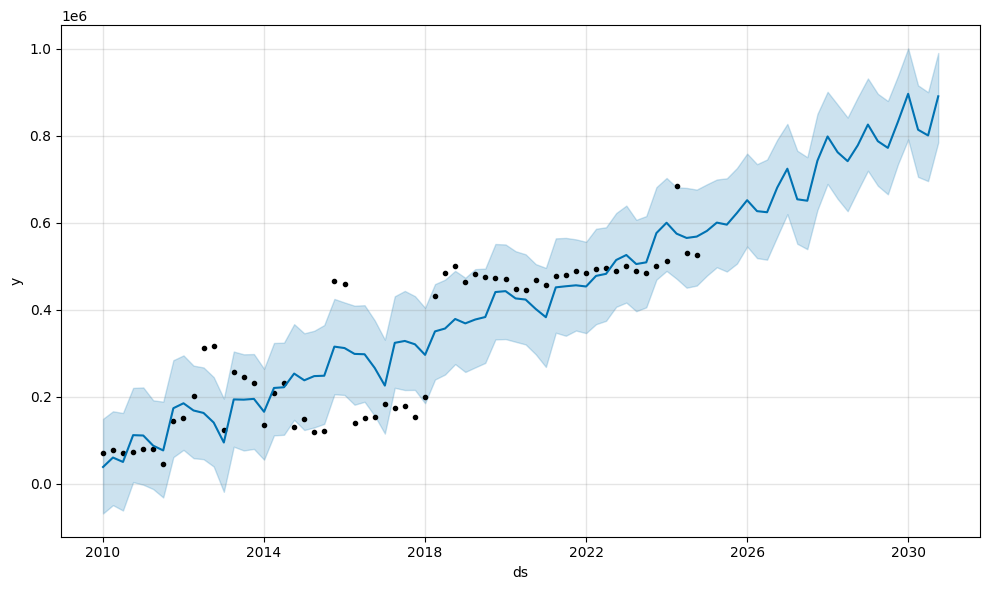

In [10]:
# Visualize
fig_low = low_model.plot(low_forecast)
fig_high = high_model.plot(high_forecast)

In [11]:
final_forecast['low_price_pred'] = final_forecast['yhat_low']
final_forecast['high_price_pred'] = final_forecast['yhat_high']

final_forecast

C:\Users\Admin\AppData\Local\Temp\ipykernel_8812\1096414309.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_forecast['low_price_pred'] = final_forecast['yhat_low']
C:\Users\Admin\AppData\Local\Temp\ipykernel_8812\1096414309.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_forecast['high_price_pred'] = final_forecast['yhat_high']


,ds,yhat_low,yhat_high,date,low_price_pred,high_price_pred
60,2025-01-01,3016.198816,581283.202322,01-01-2025,3016.198816,581283.202322
61,2025-04-01,2935.748979,600423.855218,01-04-2025,2935.748979,600423.855218
62,2025-07-01,2964.506377,595705.854814,01-07-2025,2964.506377,595705.854814
63,2025-10-01,2978.128571,622707.582043,01-10-2025,2978.128571,622707.582043
64,2026-01-01,2850.496959,651902.956170,01-01-2026,2850.496959,651902.956170
65,2026-04-01,2917.454885,626748.877113,01-04-2026,2917.454885,626748.877113
66,2026-07-01,2974.157910,624228.773447,01-07-2026,2974.157910,624228.773447
67,2026-10-01,2950.769240,680880.020176,01-10-2026,2950.769240,680880.020176
68,2027-01-01,2697.644600,724276.001788,01-01-2027,2697.644600,724276.001788
69,2027-04-01,2908.702014,654001.358425,01-04-2027,2908.702014,654001.358425


In [12]:
final_forecast['Average_Price'] = (final_forecast['yhat_low'] + final_forecast['yhat_high']) / 2
final_forecast

C:\Users\Admin\AppData\Local\Temp\ipykernel_8812\2993698906.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_forecast['Average_Price'] = (final_forecast['yhat_low'] + final_forecast['yhat_high']) / 2


,ds,yhat_low,yhat_high,date,low_price_pred,high_price_pred,Average_Price
60,2025-01-01,3016.198816,581283.202322,01-01-2025,3016.198816,581283.202322,292149.700569
61,2025-04-01,2935.748979,600423.855218,01-04-2025,2935.748979,600423.855218,301679.802099
62,2025-07-01,2964.506377,595705.854814,01-07-2025,2964.506377,595705.854814,299335.180596
63,2025-10-01,2978.128571,622707.582043,01-10-2025,2978.128571,622707.582043,312842.855307
64,2026-01-01,2850.496959,651902.956170,01-01-2026,2850.496959,651902.956170,327376.726565
65,2026-04-01,2917.454885,626748.877113,01-04-2026,2917.454885,626748.877113,314833.165999
66,2026-07-01,2974.157910,624228.773447,01-07-2026,2974.157910,624228.773447,313601.465679
67,2026-10-01,2950.769240,680880.020176,01-10-2026,2950.769240,680880.020176,341915.394708
68,2027-01-01,2697.644600,724276.001788,01-01-2027,2697.644600,724276.001788,363486.823194
69,2027-04-01,2908.702014,654001.358425,01-04-2027,2908.702014,654001.358425,328455.030219


In [13]:
final_forecast['QoQ_Price_Change_Percent(%)'] = np.nan

C:\Users\Admin\AppData\Local\Temp\ipykernel_8812\2726212140.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_forecast['QoQ_Price_Change_Percent(%)'] = np.nan


In [14]:
last_average = final_forecast['Average_Price'].iloc[-1:].values

In [15]:
for n in range(final_forecast.shape[0]):
    if n == 0:
        final_forecast['QoQ_Price_Change_Percent(%)'].values[n] = ((final_forecast['Average_Price'].values[n] - last_average) / last_average) * 100
    else:
        final_forecast['QoQ_Price_Change_Percent(%)'].values[n] = ((final_forecast['Average_Price'].values[n] - final_forecast['Average_Price'].values[n-1]) / final_forecast['Average_Price'].values[n-1]) * 100
        

C:\Users\Admin\AppData\Local\Temp\ipykernel_8812\1160122624.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  final_forecast['QoQ_Price_Change_Percent(%)'].values[n] = ((final_forecast['Average_Price'].values[n] - last_average) / last_average) * 100


In [16]:
del final_forecast['ds']
del final_forecast['yhat_low']
del final_forecast['yhat_high']

final_forecast

,date,low_price_pred,high_price_pred,Average_Price,QoQ_Price_Change_Percent(%)
60,01-01-2025,3016.198816,581283.202322,292149.700569,-34.606676
61,01-04-2025,2935.748979,600423.855218,301679.802099,3.262061
62,01-07-2025,2964.506377,595705.854814,299335.180596,-0.777189
63,01-10-2025,2978.128571,622707.582043,312842.855307,4.512558
64,01-01-2026,2850.496959,651902.956170,327376.726565,4.645742
65,01-04-2026,2917.454885,626748.877113,314833.165999,-3.831537
66,01-07-2026,2974.157910,624228.773447,313601.465679,-0.391223
67,01-10-2026,2950.769240,680880.020176,341915.394708,9.028634
68,01-01-2027,2697.644600,724276.001788,363486.823194,6.308996
69,01-04-2027,2908.702014,654001.358425,328455.030219,-9.637706


In [17]:
# Save forecast data
final_forecast.to_csv('price_forecasts_2025-2030.csv', index=False)

In [18]:
import joblib

# Save models
joblib.dump(low_model, 'low_price_prophet_model.pkl')
joblib.dump(high_model, 'high_price_prophet_model.pkl')

['high_price_prophet_model.pkl']